# Similarity-Based Drill Targeting – Synthetic One-Class SVM & MHD Demo

**Author:** Adel Asadi  
**Affiliation:** Stanford University – Mineral-X Group  

This notebook accompanies the manuscript:

> **"Exploration Drill Targeting based on Similarity with Known Economical Mineral Deposits"**

The goal here is to illustrate, on simple **synthetic 2D geophysical data**, the main steps of the
similarity-based workflow used in the paper:

1. Generate three synthetic "anomalies" in the space of two geophysical parameters.  
   - Anomalies **A** and **B** are designed to have **good overlap** in feature space  
   - Anomaly **C** is more distant, with only limited spatial overlap in the bivariate space  

2. Fit a **one-class Support Vector Machine (OC-SVM)** to each anomaly to approximate the
   high-dimensional boundary of the data (analogous to the “convex hull” in the paper).

3. Use **Modified Hausdorff Distance (MHD)** to quantify the similarity between pairs of OC-SVM
   boundaries:
   - Small MHD → similar anomalies (A vs B)  
   - Larger MHD → dissimilar anomalies (A vs C)

4. Visualize each step:
   - Bivariate synthetic data (all anomalies together, then separately)  
   - OC-SVM decision boundaries for each anomaly  
   - Overlaid boundaries showing **close vs far** cases with the corresponding MHD values

Throughout the notebook, the axes are labeled as Geophysical Parameters 1 and 2 to emphasize that this is a conceptual example in geophysical feature space.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.metrics import pairwise_distances

# For reproducibility
np.random.seed(42)

def modified_hausdorff_distance(A: np.ndarray, B: np.ndarray) -> float:
    """
    Compute the Modified Hausdorff Distance (MHD) between two point sets A and B.

    MHD is defined as the maximum of:
      - the average minimum distance from points in A to B
      - the average minimum distance from points in B to A

    Reference:
      Dubuisson & Jain (1994), "A modified Hausdorff distance for object matching".

    Parameters
    ----------
    A : array of shape (n_points_A, dim)
    B : array of shape (n_points_B, dim)

    Returns
    -------
    float
        The modified Hausdorff distance between A and B.
    """
    D = pairwise_distances(A, B)
    h_ab = np.mean(np.min(D, axis=1))  # A -> B
    h_ba = np.mean(np.min(D, axis=0))  # B -> A
    return max(h_ab, h_ba)


## 1. Synthetic bivariate anomalies

In this step we generate three synthetic "anomalies" in 2D geophysical feature space:

- **Anomaly A** – reference anomaly (centered near (0, 0))  
- **Anomaly B** – similar to A (slightly shifted; good overlap)  
- **Anomaly C** – farther away in feature space (still with small overlap)

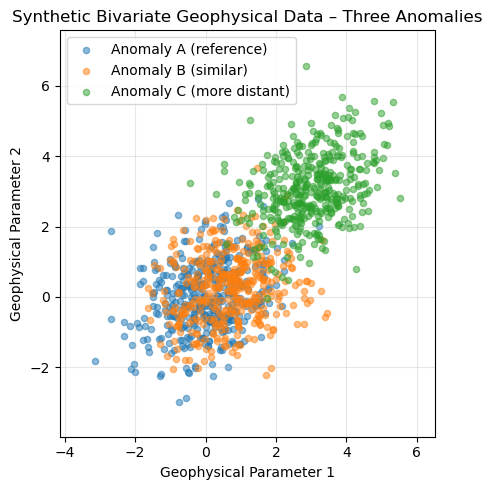

In [2]:
# -----------------------------
# 1. Generate synthetic data
# -----------------------------

n_samples = 400  # number of points per anomaly

# Shared covariance matrix (controls elongation/orientation of clouds)
cov = np.array([[1.0, 0.3],
                [0.3, 1.0]])

# Anomaly A: centered near (0, 0)
mean_A = np.array([0.0, 0.0])
A = np.random.multivariate_normal(mean_A, cov, size=n_samples)

# Anomaly B: slightly shifted; still overlapping A
mean_B = np.array([0.8, 0.3])
B = np.random.multivariate_normal(mean_B, cov, size=n_samples)

# Anomaly C: farther away, but not completely separate (some overlap)
mean_C = np.array([3.0, 3.0])
C = np.random.multivariate_normal(mean_C, cov, size=n_samples)

# Combine for axis limits
all_data = np.vstack([A, B, C])
xmin, ymin = all_data.min(axis=0) - 1.0
xmax, ymax = all_data.max(axis=0) + 1.0

# -----------------------------
# 2. Plot all anomalies together
# -----------------------------

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(A[:, 0], A[:, 1], s=20, alpha=0.5, label="Anomaly A (reference)")
ax.scatter(B[:, 0], B[:, 1], s=20, alpha=0.5, label="Anomaly B (similar)")
ax.scatter(C[:, 0], C[:, 1], s=20, alpha=0.5, label="Anomaly C (more distant)")

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Geophysical Parameter 1")
ax.set_ylabel("Geophysical Parameter 2")
ax.set_title("Synthetic Bivariate Geophysical Data – Three Anomalies")
ax.legend(loc="upper left")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.1 Individual anomaly views

Here we visualize each anomaly separately to highlight their bivariate spreads.

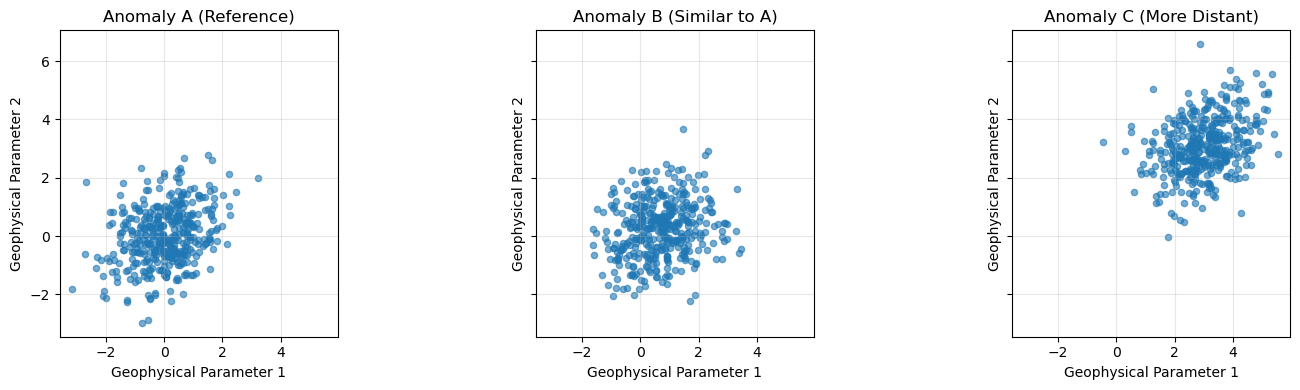

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

for data, title, ax in zip(
    [A, B, C],
    ["Anomaly A (Reference)", "Anomaly B (Similar to A)", "Anomaly C (More Distant)"],
    axes
):
    ax.scatter(data[:, 0], data[:, 1], s=20, alpha=0.6)
    ax.set_xlabel("Geophysical Parameter 1")
    ax.set_ylabel("Geophysical Parameter 2")
    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. One-Class SVM (OC-SVM) boundaries

We now fit a separate **one-class SVM** to each anomaly.  
The OC-SVM is used as a non-linear "convex hull" in feature space:
it learns a boundary that encloses the majority of the data.

- Kernel: **RBF** (Gaussian), to allow non-linear boundaries  
- gamma: Kernel coefficient for ‘rbf’  
- `nu=0.05`: upper bound on the fraction of training points that are allowed to be outside the boundary  
  (here, we allow ~5% of points to be treated as outliers)

Later, we will use the **support vectors** of each model as a set of points that approximate the
boundary for computing the Modified Hausdorff Distance.

In [4]:
# -----------------------------
# 3. Fit OC-SVM models
# -----------------------------

ocsvm_params = dict(kernel="rbf", gamma=0.15, nu=0.05)

svm_A = OneClassSVM(**ocsvm_params).fit(A)
svm_B = OneClassSVM(**ocsvm_params).fit(B)
svm_C = OneClassSVM(**ocsvm_params).fit(C)

# Extract support vectors as boundary points for later MHD calculation
sv_A = svm_A.support_vectors_
sv_B = svm_B.support_vectors_
sv_C = svm_C.support_vectors_

print("Number of support vectors (approximate boundary points):")
print(f"  Anomaly A: {len(sv_A)}")
print(f"  Anomaly B: {len(sv_B)}")
print(f"  Anomaly C: {len(sv_C)}")

Number of support vectors (approximate boundary points):
  Anomaly A: 22
  Anomaly B: 23
  Anomaly C: 23


### 2.1 Visualizing OC-SVM decision boundaries

For each anomaly, we plot:

- The data points of the anomaly

To keep the visualization simple, we **do not plot the support vectors explicitly**;
only the decision boundary curve is shown.

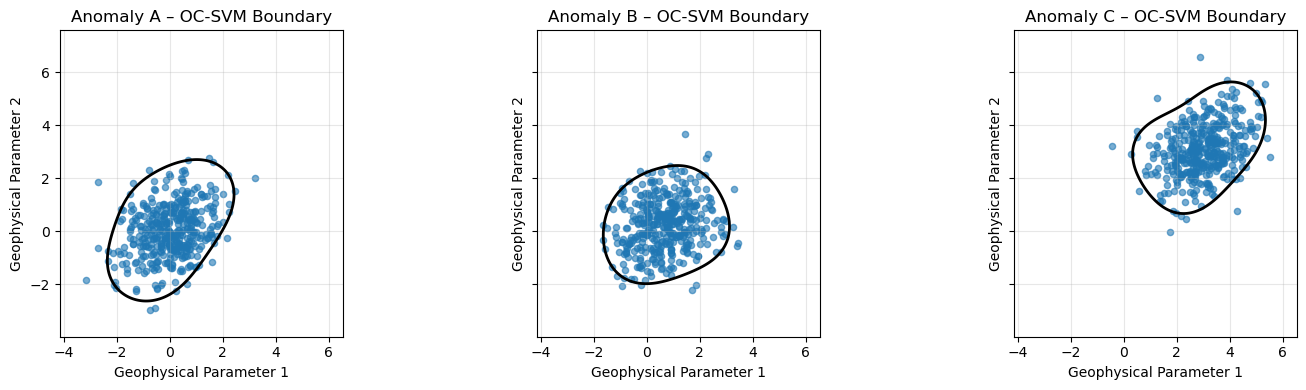

In [5]:
def plot_ocsvm_boundary(ax, data, clf, title):
    """
    Plot anomaly data and the OC-SVM boundary.

    Parameters
    ----------
    ax : matplotlib Axes
        Axes on which to plot.
    data : ndarray of shape (n_samples, 2)
        Data points for one anomaly.
    clf : fitted OneClassSVM
    title : str
        Axes title.
    """
    # Scatter the data points
    ax.scatter(data[:, 0], data[:, 1], s=20, alpha=0.6)

    # Create a grid in feature space
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, 300),
        np.linspace(ymin, ymax, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Decision function values on the grid
    Z = clf.decision_function(grid).reshape(xx.shape)

    # Plot only the decision boundary f(x) = 0
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="solid", colors="k")

    ax.set_xlabel("Geophysical Parameter 1")
    ax.set_ylabel("Geophysical Parameter 2")
    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.3)


# Plot boundaries for all three anomalies
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

plot_ocsvm_boundary(axes[0], A, svm_A, "Anomaly A – OC-SVM Boundary")
plot_ocsvm_boundary(axes[1], B, svm_B, "Anomaly B – OC-SVM Boundary")
plot_ocsvm_boundary(axes[2], C, svm_C, "Anomaly C – OC-SVM Boundary")

plt.tight_layout()
plt.show()

## 3. Modified Hausdorff Distance (MHD) between anomaly boundaries

To quantify similarity between anomalies, we treat the **support vectors** of each
OC-SVM as samples of the boundary in feature space.

We then compute the **Modified Hausdorff Distance** between pairs of boundary point sets:

- **MHD(A, B)** – two similar anomalies with good overlap  
- **MHD(A, C)** – more distant anomalies with limited overlap

A smaller MHD indicates that the boundaries are close to each other and therefore that the
multivariate anomaly patterns are similar. A larger MHD indicates more dissimilar anomalies.

In [6]:
# Compute MHD between boundary point sets (support vectors)
mhd_AB = modified_hausdorff_distance(sv_A, sv_B)
mhd_AC = modified_hausdorff_distance(sv_A, sv_C)
mhd_BC = modified_hausdorff_distance(sv_B, sv_C)

print("Modified Hausdorff Distance between OC-SVM boundaries:")
print(f"  MHD(A, B)  – similar anomalies      : {mhd_AB:.3f}")
print(f"  MHD(A, C)  – more distant anomalies : {mhd_AC:.3f}")
print(f"  MHD(B, C)  – more distant anomalies : {mhd_BC:.3f}")

Modified Hausdorff Distance between OC-SVM boundaries:
  MHD(A, B)  – similar anomalies      : 0.784
  MHD(A, C)  – more distant anomalies : 2.207
  MHD(B, C)  – more distant anomalies : 1.937


## 4. Visual comparison of "close" vs "far" anomaly boundaries

Finally, we overlay the OC-SVM boundaries for:

- **Anomaly A vs B** (expected to be close)  
- **Anomaly A vs C** (expected to be more distant)

Each subplot shows only the learned boundaries for the two anomalies, and the
corresponding MHD value is annotated in the title.

C:\Users\aasadi1\AppData\Local\Temp\ipykernel_33472\3977563431.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, Z1, levels=[0], linewidths=2, linestyles="solid",
C:\Users\aasadi1\AppData\Local\Temp\ipykernel_33472\3977563431.py:19: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, Z2, levels=[0], linewidths=2, linestyles="dashed",
C:\Users\aasadi1\AppData\Local\Temp\ipykernel_33472\3977563431.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, Z1, levels=[0], linewidths=2, linestyles="solid",
C:\Users\aasadi1\AppData\Local\Temp\ipykernel_33472\3977563431.py:19: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, Z2, levels=[0], linewidths=2, linestyles="dashed",


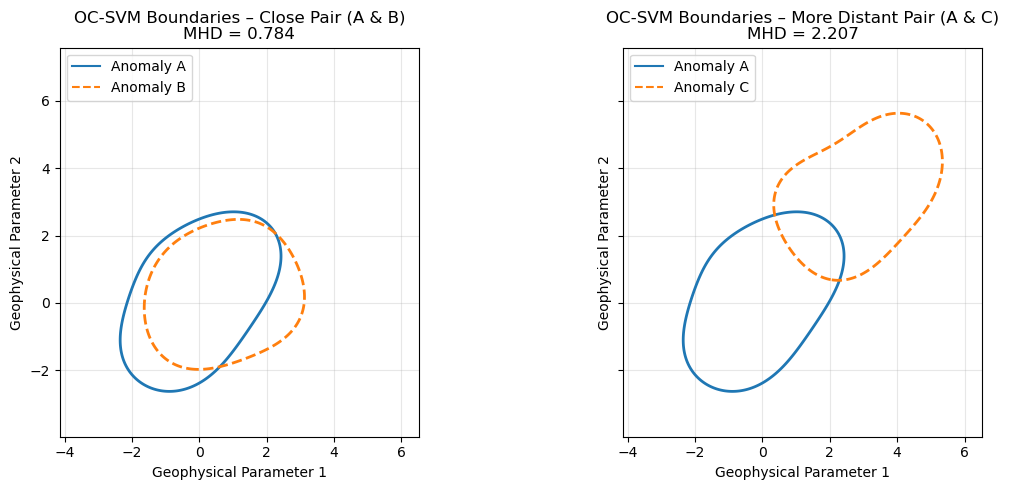

In [7]:
def plot_overlaid_boundaries(ax, clf1, clf2, label1, label2, title_prefix, mhd_value):
    """
    Plot OC-SVM boundaries of two anomalies together (no data points),
    and annotate the MHD value in the title.
    """
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, 400),
        np.linspace(ymin, ymax, 400)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Decision function for both models
    Z1 = clf1.decision_function(grid).reshape(xx.shape)
    Z2 = clf2.decision_function(grid).reshape(xx.shape)

    # Boundary f(x) = 0 for each anomaly
    ax.contour(xx, yy, Z1, levels=[0], linewidths=2, linestyles="solid",
               colors="tab:blue", label=label1)
    ax.contour(xx, yy, Z2, levels=[0], linewidths=2, linestyles="dashed",
               colors="tab:orange", label=label2)

    # Dummy lines for legend
    ax.plot([], [], color="tab:blue", linestyle="solid", label=label1)
    ax.plot([], [], color="tab:orange", linestyle="dashed", label=label2)

    ax.set_xlabel("Geophysical Parameter 1")
    ax.set_ylabel("Geophysical Parameter 2")
    ax.set_title(f"{title_prefix}\nMHD = {mhd_value:.3f}")
    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="upper left")
    ax.grid(True, alpha=0.3)


fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Close pair: A vs B
plot_overlaid_boundaries(
    axes[0], svm_A, svm_B,
    label1="Anomaly A", label2="Anomaly B",
    title_prefix="OC-SVM Boundaries – Close Pair (A & B)",
    mhd_value=mhd_AB
)

# More distant pair: A vs C
plot_overlaid_boundaries(
    axes[1], svm_A, svm_C,
    label1="Anomaly A", label2="Anomaly C",
    title_prefix="OC-SVM Boundaries – More Distant Pair (A & C)",
    mhd_value=mhd_AC
)

plt.tight_layout()
plt.show()

## 5. Summary

This synthetic example reproduces the core ideas of the similarity-based drill-targeting
workflow presented in the manuscript:

1. **Anomalies A and B** occupy largely overlapping regions in the space of two
   geophysical parameters. Their one-class SVM boundaries are close, and the
   **Modified Hausdorff Distance MHD(A, B)** is small.

2. **Anomaly C** is more distant in feature space. The OC-SVM boundary for C is
   clearly separated from that of A, and **MHD(A, C)** is significantly larger.

3. The combination of **OC-SVM boundaries** and **MHD** provides a quantitative way
   to rank anomalies by their similarity to a reference anomaly, exactly as done
   in the full Curaçá Valley case study but here in a transparent 2D setting.